In [209]:
import re, requests, string
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn import preprocessing
from pywaffle import Waffle

# COVID-19 and the public health care around the world
## Cities Dataset Pre-processing

First, we need to read the cities dataset from the [Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_cities).

In [66]:
wiki_cities = 'https://en.wikipedia.org/wiki/List_of_largest_cities'
cities_rq = requests.get(wiki_cities)

The following snippet pre-process the dataframe, forces the `int` type for numeric columns and removes invalid values.

In [67]:
soup_cities = BeautifulSoup(cities_rq.text, 'html.parser')
table_cities = soup_cities.find_all('table')[1]
cities_df = pd.read_html(str(table_cities))[0]

# Removes columns multindex, renames and capitalizes the labels
cities_df.columns = cities_df.columns.map(' '.join).str.strip(' ')
cities_df.columns = map(lambda x: string.capwords(x), cities_df.columns)
cities_df.rename(columns={'City City': 'City', 'Country Country': 'Country', 'Skyline Skyline': 'Skyline','City Proper Definition': 'City Definition', 'City Proper Population': 'City Population', 'City Proper Area(km2)': 'City Area(km2)','Urban Area[9] Population': 'Urban Population','Urban Area[9] Area(km2)': 'Urban Area(km2)', 'Metropolitan Area Area(km2)': 'Metropolitan Area(km2)', 'Metropolitan Area Population': 'Metropolitan Population'}, inplace = True)

# Removes invalid characters from the columns
for col in ['City Population','City Area(km2)', 'Metropolitan Population','Metropolitan Area(km2)', 'Urban Area(km2)']: 
    cities_df[col] = cities_df[col].str.replace(r'\[[0-9A-Za-z]+\]', '')
    
# Process invalid values
cities_df['Metropolitan Population'].fillna(cities_df['City Population'], inplace=True)
cities_df['Metropolitan Area(km2)'].fillna(cities_df['City Area(km2)'], inplace=True)
cities_df.dropna(subset=['City Population'], inplace=True)
cities_df.drop(columns=['Skyline'], inplace=True)

# Forces int type for numeric columns
for col in ['City Population', 'City Area(km2)', 'Metropolitan Population', 'Metropolitan Area(km2)', 'Urban Area(km2)']:
    cities_df[col] = cities_df[col].str.replace(',', '').astype(int)
    
cities_df = cities_df.sort_values(by='City Population', ascending=False).reset_index(drop=True)

In [143]:
cities_df.head()

,City,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2)
0,Chongqing,China,Municipality,30752000,82403,30752000,82403,8300000,1489
1,Shanghai,China,Municipality,24183000,6341,24183000,6341,22125000,4015
2,Beijing,China,Municipality,21707000,16411,21707000,16411,19430000,4144
3,Delhi,India,National capital territory,16753235,1484,29000000,3483,28125000,2240
4,Chengdu,China,City (sub-provincial),16044700,14378,16044700,14378,12160000,1813


In [147]:
cities_df.describe(include='all')

,City,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2)
count,76,76,76,7.600000e+01,76.000000,7.600000e+01,76.000000,7.600000e+01,76.000000
unique,76,33,25,NaN,NaN,NaN,NaN,NaN,NaN
top,Dallas,China,Municipality,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,22,19,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,8.224308e+06,5685.013158,1.188086e+07,8820.671053,1.181204e+07,2305.815789
std,NaN,NaN,NaN,5.656770e+06,11988.741757,7.129669e+06,11946.137187,7.314714e+06,2125.370228
min,NaN,NaN,NaN,2.364530e+05,22.000000,1.555985e+06,105.000000,1.250000e+06,220.000000
25%,NaN,NaN,NaN,3.106918e+06,407.250000,7.253175e+06,1831.250000,6.652500e+06,964.750000
50%,NaN,NaN,NaN,8.318250e+06,1537.000000,9.570169e+06,6133.500000,9.457500e+06,1651.500000
75%,NaN,NaN,NaN,1.090192e+07,6401.250000,1.440405e+07,12079.750000,1.527125e+07,2850.000000


### Population size and number of cities per country

In [187]:
countries = cities_df[['City', 'Country', 'City Population']].groupby('Country').sum().sort_values(by='City Population', ascending=False).rename(columns={'City Population': 'Cities Population'})
countries['Cities'] = cities_df[['City', 'Country']].groupby('Country').count()
countries.head(10)

,Cities Population,Cities
Country,,
China,279153800,22
India,69054182,9
Pakistan,26036352,2
United States,21046090,8
Brazil,18772023,2
Japan,18560638,3
Indonesia,15482229,3
Turkey,15029231,1
Vietnam,14663700,2


In [260]:
print('There are {} cities on the dataset, from {} countries.'.format(countries['Cities'].sum(), countries['Cities'].count()))

There are 76 cities on the dataset, from 33 countries.


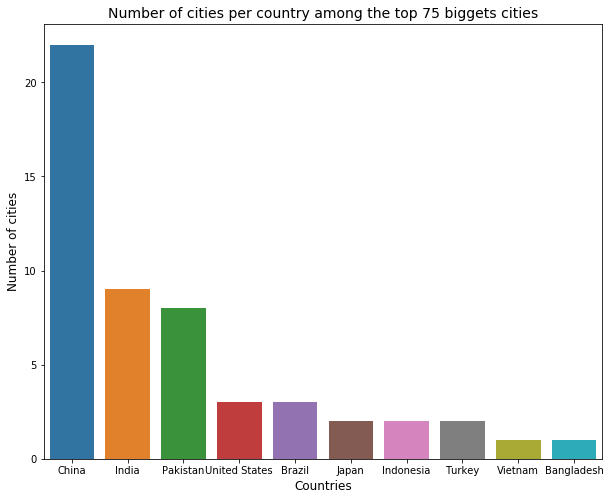

In [254]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=countries[:10].index, y='Cities', data=countries[:10].sort_values('Cities', ascending=False))
plt.ylabel('Number of cities', fontsize=12)
plt.xlabel('Countries', fontsize=12)
plt.title('Number of cities per country among the top 75 biggets cities', fontsize=14);

As seen above, 22 out 75 of the biggest cities on the world are from China.

In [248]:
countries[:5]['Cities'].sum()

43

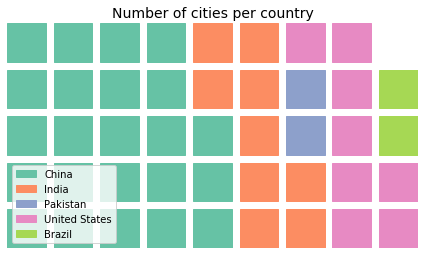

In [251]:
waffle = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=9,
    values=countries[:5]['Cities'],
    labels=list(countries[:5].index),
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, 0)}
)
plt.title('Number of cities per country', fontsize=14);
plt.show();

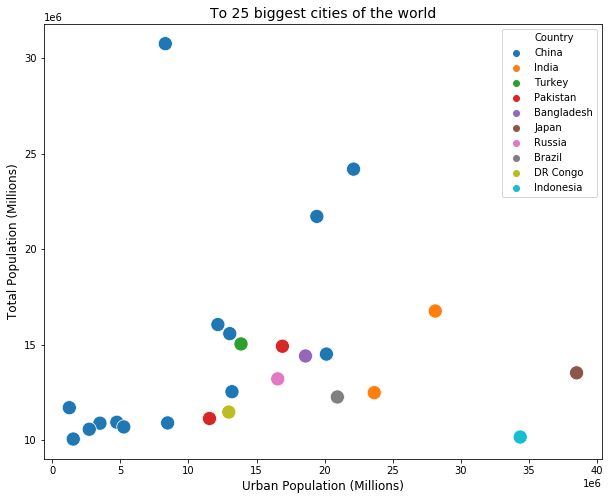

In [165]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='Urban Population', y='City Population', data=cities_df[:25], hue='Country', s=200)
plt.ticklabel_format(scilimits=(6,6), axis='both')
plt.ylabel('Total Population (Millions)', fontsize=12)
plt.xlabel('Urban Population (Millions)', fontsize=12)
plt.title('To 25 biggest cities of the world', fontsize=14);